# Machine Learning For Trading

## History Data

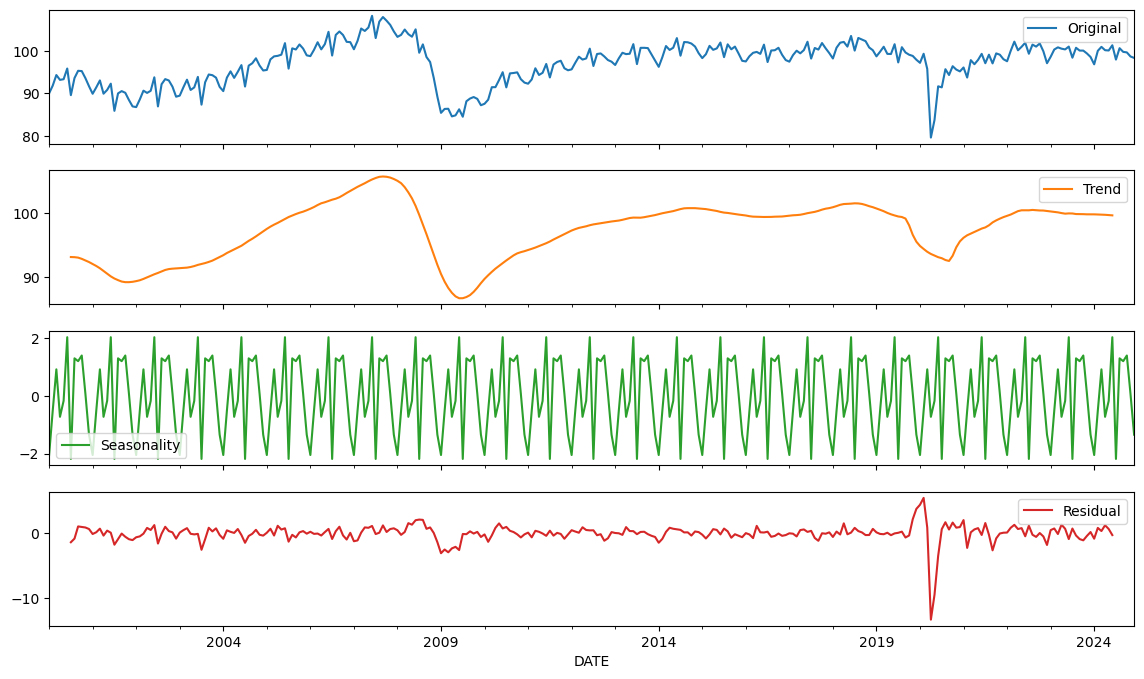

In [20]:
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa

industrial_production = web.DataReader('IPGMFN', 'fred', '2000', '2024-12').squeeze()
components = tsa.seasonal_decompose(industrial_production, model='additive')
ts = (industrial_production.to_frame('Original')
 .assign(Trend=components.trend)
 .assign(Seasonality=components.seasonal)
 .assign(Residual=components.resid))
ts.plot(subplots=True, figsize=(14, 8));

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from arch import arch_model
import pandas_datareader.data as web

nasdaq = web.DataReader('NASDAQCOM', 'fred', '2015', '2020').squeeze()
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100) 
trainsize = 3 * 252 # 10 years
data = nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05), upper=nasdaq_returns.quantile(.95))
T = len(nasdaq_returns)
results = {}
for p in range(2, 3):
    for q in range(2, 3):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s: t]
            test_set = data.iloc[t+1] # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

2 | 2


In [2]:
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
import pandas as pd

am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(.05), upper=nasdaq_returns.quantile(.95)))
am.volatility = GARCH(2, 0, 2)
am.distribution = Normal()
best_model = am.fit(update_freq=5)
print(best_model.summary())

Iteration:      5,   Func. Count:     45,   Neg. LLF: 1439.5583954122712
Iteration:     10,   Func. Count:     83,   Neg. LLF: 1424.6943449021578
Iteration:     15,   Func. Count:    117,   Neg. LLF: 1424.685978150334
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1424.6859781498922
            Iterations: 15
            Function evaluations: 117
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1424.69
Distribution:                  Normal   AIC:                           2861.37
Method:            Maximum Likelihood   BIC:                           2891.98
                                        No. Observations:                 1214
Date:             

In [3]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '2020', '2024-10').dropna()
df.columns = ['sentiment', 'ip']
df.head()

,sentiment,ip
DATE,,
2020-01-01,99.8,97.2335
2020-02-01,101.0,99.3741
2020-03-01,89.1,95.7827
2020-04-01,71.8,79.6086
2020-05-01,72.3,83.7649


## backtesting

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [5]:
CSI300 = pd.read_csv('CSI300.csv')
CSI300.dropna(inplace=True)
CSI300.drop(columns=['Unnamed: 0'], inplace=True)
CSI300.head()

,Ticker,Company,Segment,Exchange,Weighting (%),yf_ticker
0,SSE: 600519,Kweichow Moutai,Consumer Staples,Shanghai,5.972,600519.SS
1,SSE: 601318,Ping An Insurance,Financials,Shanghai,2.590,601318.SS
2,SZSE: 300750,CATL,Industrials,Shenzhen,2.421,300750.SZ
3,SSE: 600036,China Merchants Bank,Financials,Shanghai,2.225,600036.SS
4,SZSE: 000333,Midea Group,Consumer Discretionary,Shenzhen,1.727,000333.SZ


In [6]:
def yf_ticker(ticker):
    return ticker[-6:] + "." +ticker[:2]

In [7]:
CSI300['yf_ticker'] = CSI300['Ticker'].apply(lambda x: yf_ticker(x))
CSI300.to_csv('CSI300.csv')

In [8]:
from datetime import datetime, timedelta

df = pd.read_csv('CSI300.csv')

tickers = df['yf_ticker'].unique().tolist()
start_date = "2025-01-01"
end_date = "2025-02-28"

# Download data for all tickers at once with group_by='ticker'
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

# Reshape the data from wide (MultiIndex columns) to long format
# The MultiIndex columns will have levels: [Price Data, Ticker]
long_data = data.stack(level=0).reset_index()

# Rename columns for clarity
long_data.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  300 of 300 completed
C:\Users\skye\AppData\Local\Temp\ipykernel_21220\3615171368.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long_data = data.stack(level=0).reset_index()


In [9]:
long_data.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2025-01-02,000001.SZ,11.730000,11.77,11.390000,11.43,181959699
1,2025-01-02,000002.SZ,7.250000,7.36,7.070000,7.11,118266605
2,2025-01-02,000063.SZ,40.389999,40.93,37.560001,37.93,329999755
3,2025-01-02,000069.SZ,2.670000,2.73,2.590000,2.62,50753451
4,2025-01-02,000100.SZ,5.030000,5.11,4.910000,4.95,587702499


In [10]:
long_data['Return'] = long_data.groupby('Ticker')['Close'].pct_change() # percentage change  
CSI_300_Return = long_data.copy()
CSI_300_Return.dropna(inplace=True)
CSI_300_Return.head()

,Date,Ticker,Open,High,Low,Close,Volume,Return
300,2025-01-03,000001.SZ,11.44,11.54,11.360000,11.380000,115468044,-0.004374
301,2025-01-03,000002.SZ,7.17,7.18,6.960000,7.000000,112491516,-0.015471
302,2025-01-03,000063.SZ,38.25,38.32,35.549999,35.650002,273493496,-0.060111
303,2025-01-03,000069.SZ,2.63,2.64,2.530000,2.550000,49325151,-0.026718
304,2025-01-03,000100.SZ,4.96,5.05,4.850000,4.880000,489907005,-0.014141


In [11]:
CSI_300_Return.to_csv('CSI_300_Return.csv')

In [12]:
df = pd.read_csv('CSI_300_Return.csv')

lowest_returns_per_day = df.groupby('Date').apply(lambda x: x.nlargest(10, 'Return'))

lowest_returns_per_day.reset_index(drop = True, inplace=True)

C:\Users\skye\AppData\Local\Temp\ipykernel_21220\3411438609.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lowest_returns_per_day = df.groupby('Date').apply(lambda x: x.nlargest(10, 'Return'))


In [13]:
lowest_returns_per_day.reset_index(drop=True)

,Unnamed: 0,Date,Ticker,Open,High,Low,Close,Volume,Return
0,571,2025-01-03,603392.SS,67.349998,73.330002,67.120003,70.680000,6608074,0.050223
1,459,2025-01-03,600547.SS,23.299999,24.219999,23.299999,24.120001,67635705,0.041901
2,307,2025-01-03,000301.SZ,8.000000,8.420000,8.000000,8.260000,28409861,0.032500
3,580,2025-01-03,603993.SS,6.610000,6.970000,6.610000,6.770000,328432488,0.028875
4,541,2025-01-03,601808.SS,15.040000,15.630000,15.040000,15.430000,21739872,0.027297
...,...,...,...,...,...,...,...,...,...
335,10213,2025-02-27,000568.SZ,121.199997,127.989998,120.800003,127.779999,28453938,0.050995
336,10477,2025-02-27,603833.SS,62.099998,65.790001,61.900002,65.190002,6016326,0.049589
337,10396,2025-02-27,601021.SS,51.970001,53.959999,51.639999,53.919998,8334874,0.043950
338,10281,2025-02-27,300015.SZ,13.900000,14.690000,13.850000,14.460000,216281349,0.043290


In [14]:
lowest_returns_per_day.to_csv('lowest_returns_per_day.csv')

In [15]:
CSI_300_Return = pd.read_csv('CSI_300_return.csv')
lowest_returns_per_day = pd.read_csv('lowest_returns_per_day.csv')

initial_capital = 100000
portfolio_value = initial_capital
investment_data = []
portfolio_value_data = []

trading_dates = sorted(lowest_returns_per_day['Date'].unique())

for i in range(len(trading_dates)-1):
    current_date = trading_dates[i]
    next_date = trading_dates[i+1]

    daily_lowest_returns = lowest_returns_per_day[lowest_returns_per_day['Date'] == current_date]

    investment_per_stock = portfolio_value / 10

    daily_investments =[]

    for index, row in daily_lowest_returns.iterrows():
        ticker = row['Ticker']
        close_price = row['Close']

        num_shares = investment_per_stock / close_price

        investment_record = {
            'Date': current_date,
            'Ticker': ticker,
            'Close Price': close_price,
            'Investment Amount': investment_per_stock,
            'Shares Purchased': num_shares 
        }
        daily_investments.append(investment_record)

    investment_data.extend(daily_investments)

    next_day_prices = CSI_300_Return[CSI_300_Return['Date'] == next_date]
    portfolio_value = 0

    for record in daily_investments:
        ticker = record['Ticker']
        num_shares = record['Shares Purchased']

        next_day_close_price = next_day_prices[next_day_prices['Ticker'] == ticker]['Close']
        if not next_day_close_price.empty:
            next_day_close_price = next_day_close_price.values[0]
        else:
            next_day_close_price = record['Close Price'] 

        portfolio_value += num_shares * next_day_close_price

    portfolio_value_data.append({
        'Date': next_date,
        'Portfolio Value': portfolio_value
    })

investment_df = pd.DataFrame(investment_data)
portfolio_value_df = pd.DataFrame(portfolio_value_data)




In [16]:
portfolio_value_df.to_csv('portfolio_value.csv')

Text(0.5, 1.0, 'Stock Price Chart')

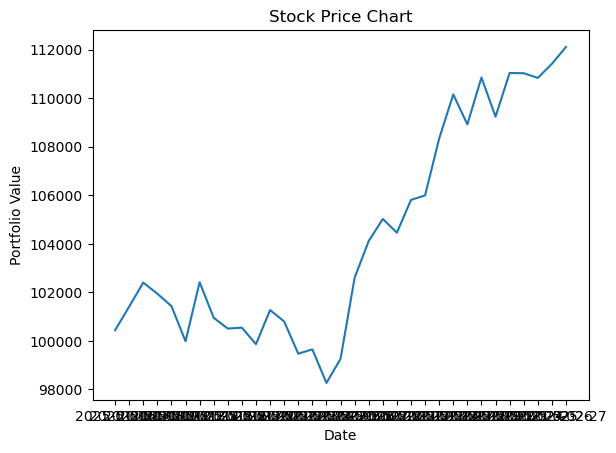

In [17]:
# read the data from csv and draw the chart

data = pd.read_csv('portfolio_value.csv')

# draw the chart
plt.plot(data['Date'], data['Portfolio Value'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Stock Price Chart')

In [18]:
portfolio_value_df = pd.read_csv('portfolio_value.csv')

csi_300_ticker = '000300.SS'
csi_300_data = yf.download(csi_300_ticker, start=portfolio_value_df['Date'].min(), end=portfolio_value_df['Date'].max())

# Extract the 'Adj Close' price for the CSI 300 index and calculate the portfolio value
initial_investment = 100000
csi_300_data['Portfolio Value'] = initial_investment * csi_300_data['Close'] / csi_300_data['Close'].iloc[0]

csi_300_data.reset_index(inplace=True)

# If the DataFrame has multi-level columns, flatten them first:
if isinstance(csi_300_data.columns, pd.MultiIndex):
    csi_300_data.columns = csi_300_data.columns.get_level_values(0)

# Now, keep only the desired columns:
csi_300 = csi_300_data[['Date', 'Portfolio Value']]

csi_300.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Portfolio Value
0,2025-01-06,100000.000000
1,2025-01-07,100720.094268
2,2025-01-08,100537.282073
3,2025-01-09,100289.466676
4,2025-01-10,99031.831229


C:\Users\skye\AppData\Local\Temp\ipykernel_21220\901995696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csi_300['Date'] = pd.to_datetime(csi_300['Date'])


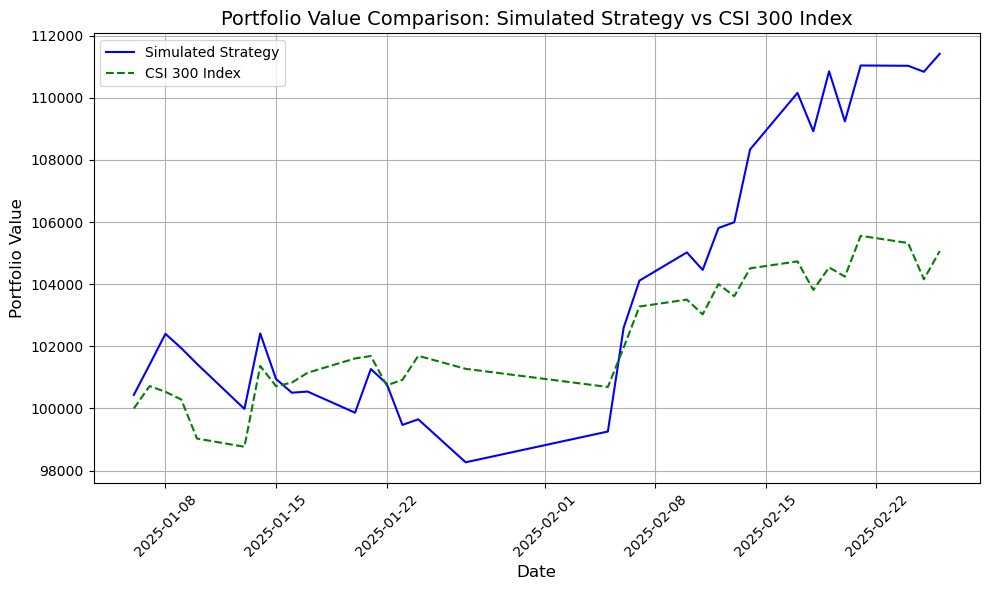

In [19]:
# Merge the simulated strategy portfolio value with the CSI 300 index portfolio value on the 'Date'
portfolio_value_df['Date'] = pd.to_datetime(portfolio_value_df['Date'])
csi_300['Date'] = pd.to_datetime(csi_300['Date'])

merged_df = pd.merge(portfolio_value_df, csi_300[['Date', 'Portfolio Value']], on='Date', how='inner', suffixes=('_Simulated', '_CSI300'))

# Plot the portfolio values of both strategies
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['Portfolio Value_Simulated'], label='Simulated Strategy', color='blue')
plt.plot(merged_df['Date'], merged_df['Portfolio Value_CSI300'], label='CSI 300 Index', color='green', linestyle='--')

# Add labels and title
plt.title('Portfolio Value Comparison: Simulated Strategy vs CSI 300 Index', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()